In [0]:
from pathlib import Path
import requests

DATA_PATH = Path('data')
PATH = DATA_PATH / 'mnist'

PATH.mkdir(parents=True, exist_ok=True)

URL = 'http://deeplearning.net/data/mnist/'
FILENAME = 'mnist.pkl.gz'

if not (PATH/FILENAME).exists():
  content = requests.get(URL + FILENAME).content
  (PATH/FILENAME).open('wb').write(content)

In [0]:
import pickle, gzip

with gzip.open((PATH / FILENAME).as_posix(), 'rb') as f:
  ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')


(50000, 784)


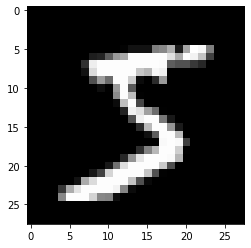

In [47]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap='gray')
print(x_train.shape)

In [0]:
import torch
import torch.nn.functional as F
x_train, y_train, x_valid, y_valid = map(torch.tensor, 
                                         (x_train, y_train, x_valid, y_valid))

n, c = x_train.shape
bs = 64 # batch size
loss_func = F.cross_entropy

In [0]:
def accuracy(out, yb):
  preds = torch.argmax(out, dim=1)
  return (preds == yb).float().mean()

In [0]:
from torch import nn

class Mnist_Logistic(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin1 = nn.Linear(784, 10)

  def forward(self, xb):
    return self.lin1(xb)

In [0]:
def loss_batch(model, loss_func, xb, yb, opt=None):
  loss = loss_func(model(xb), yb)

  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()
  
  return loss.item(), len(xb)

In [0]:
def get_data(train_ds, valid_ds, bs):
  return (
      DataLoader(train_ds, batch_size=bs, shuffle=2),
      DataLoader(valid_ds, batch_size=bs*2)
  )

In [0]:
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

lr = 0.5
epochs = 2

def get_model():
  model = Mnist_Logistic()
  opt = optim.SGD(model.parameters(), lr=lr)
  return model, opt

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
  for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
      loss_batch(model, loss_func, xb, yb, opt)

      model.eval()
      with torch.no_grad():
        losses, nums = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl])
    val_loss = np.multiply(losses, nums) / np.sum(nums)
    print(epoch, val_loss)

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)


In [0]:
class Mnist_CNN(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
    self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

  def forward(self, xb):
    xb = xb.view(-1, 1, 28, 28)
    xb = F.relu(self.conv1(xb))
    xb = F.relu(self.conv2(xb))
    xb = F.relu(self.conv3(xb))
    xb = F.avg_pool2d(xb, 4)
    xb = xb.view(-1, xb.size(1))
    return xb

lr = 0.1


In [0]:
# Training tek katman ile
model, opt = get_model()
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)


print('Bir tane training setinin buyuklugu: (bi fotografa denk geliyor)\n', train_ds[0][0].shape)

In [0]:
# Bi CNN ile model egitme
model = Mnist_CNN()
opt = optim.SGD(params=model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Sequential sinfinin kullanilabilmesi icin, verilen butun parametrelerin bi Katman olmasi lazim ve bunun icinde bu pytorch'da kendiliginden katman olarak tanimlanmamis olan *view* fonksiyonunu bi katmanin icerisine yerlestiriyoruz.

In [0]:
class Lambda(nn.Module):
  def __init__(self, func):
    super().__init__()
    self.func = func

  def forward(self, x):
    return self.func(x)

def preprocess(x):
  return x.view(-1, 1, 28, 28)

In [62]:
model = nn.Sequential(
  Lambda(preprocess),
  nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
  nn.ReLU(),
  nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
  nn.ReLU(),
  nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
  nn.ReLU(),
  nn.AvgPool2d(4),
  Lambda(lambda x: x.view(x.size(0), -1))
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 [0.01627618 0.01627596 0.01546133 0.01623606 0.01644765 0.01580028
 0.01978143 0.01428969 0.01485874 0.01600386 0.01627361 0.01756359
 0.01660222 0.01318102 0.01466861 0.01660988 0.0178837  0.01674978
 0.01536376 0.01721043 0.01538319 0.01745984 0.01677218 0.01478941
 0.01472038 0.01559989 0.01389513 0.01590144 0.01474659 0.01477699
 0.01570907 0.0181462  0.01617365 0.01370165 0.01363198 0.01768688
 0.01395415 0.01271522 0.01818231 0.01533999 0.01515304 0.01469462
 0.01758248 0.01596851 0.01718561 0.01619438 0.01454601 0.01612383
 0.01714757 0.01313262 0.01841924 0.01756952 0.01655707 0.01827919
 0.0149174  0.01559845 0.01737865 0.01439605 0.01765382 0.01463038
 0.01538289 0.01291294 0.01328556 0.01486002 0.01394495 0.01601467
 0.01497835 0.01645041 0.01410202 0.01527705 0.01247604 0.01492103
 0.01593821 0.0177021  0.01389078 0.01499355 0.01636815 0.01556807
 0.00179643]
1 [0.01528608 0.01519614 0.01498181 0.01564654 0.01458156 0.01479789
 0.01801859 0.01409745 0.01350259 0.01522856 